# Detection using Faster R-CNN

This notebook contains a process of creating an end to end Faster R-CNN model using tensorflow. First features are extracted from the images using a CNN model and then passed through a Region Proposal Network(RPN). All due credit for the algorithm goes to the authors of the paper, *Faster R-CNN: Towards Real-Time Object
Detection with Region Proposal Networks*.

It is divided up into 3 notebooks:

1. [Part 1](https://www.kaggle.com/apollo2506/ship-detection-using-faster-r-cnn-part-1): Creating a model for classifying the ROIs into the 2 classes, *ship* and *no-ship* .
2. [Part 2](https://www.kaggle.com/apollo2506/ship-detection-using-faster-r-cnn-part-2): Using Selective Search for obtaining ROIs and testing of model on geospatial data.
3. Part 3: Using Regional Proposal Networks to obtain the Region of Interests thereby decreasing computation time. Faster R-CNN

Version 4: Using numpy array and custom data augmentation tool instead of ImageDataGenerator.

Version 5: Incorporated data augmentation of *ship* class, along with an option for using class weights instead.

Version 6: Training on augmented data for Parts *2 and 3*.

# Importing libraries

The necessary libraries required for implementing the Faster R-CNN model are imported in the code block below.

In [1]:
# Python 3.8.12

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, cv2, pickle, json, itertools
import imgaug.augmenters as iaa
import imgaug.imgaug

from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *

import pydot
import pydotplus
import graphviz

2024-03-11 10:17:43.427459: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/cv2/../../lib64:
2024-03-11 10:17:43.427510: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Utility functions

* show_final_history - For plotting the loss and accuracy of the training and validation datasets
* plot_confusion_matrix - For plotting the percentage of true positives per class for a better feel of how the model predicted the data

In [3]:
def show_final_history(history):

    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')

    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show();
    pass

In [4]:
def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):

#     np.seterr(divide='ignore',invalid='ignore')
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

# Uploading the images

The images from the **satellite-imagery-of-ships** is loaded into numpy arrays, with labels [0,1] corresponding to the classes *no-ship* and *ship*. The data was loaded into numpy arrays as data augmentation and upsampling/downsampling is easier to perform. 

In [5]:
datasets = ['../../data_copy/data_train']

class_names = ["no-plane","plane"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'no-plane': 0, 'plane': 1}

In [6]:
type(datasets)

list

In [7]:
def load_data():
    images, labels = [], []

    for dataset in datasets:

        for folder in os.listdir(dataset):

            label = class_name_labels[folder]

            for file in tqdm(os.listdir(os.path.join(dataset,folder))):

                img_path = os.path.join(dataset,folder,file)

                img = cv2.imread(img_path)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                #img = cv2.resize(img, (48,48))

                images.append(img)
                labels.append(label)
                pass
            pass

        images = np.array(images,dtype=np.float32)/255.0
        labels = np.array(labels,dtype=np.float32)
        pass

    return (images, labels)
    pass

In [8]:
(images, labels) = load_data()
images.shape, labels.shape

 11%|█▏        | 904/8000 [00:00<00:06, 1143.04it/s]

100%|██████████| 24000/24000 [00:10<00:00, 2302.77it/s]


((32000, 20, 20, 3), (32000,))

In [9]:
type(images)

numpy.ndarray

# EDA of dataset

* bar-plot - Bar plot is made to find the count of images per class
* pie-plot - Pie plot is drawn to find the percentage of class distribution in the dataset

In [10]:
n_labels = labels.shape[0]

_, count = np.unique(labels, return_counts=True)

df = pd.DataFrame(data = count)
df['Class Label'] = class_names
df.columns = ['Count','Class-Label']
df.set_index('Class-Label',inplace=True)
df

,Count
Class-Label,
no-plane,24000
plane,8000


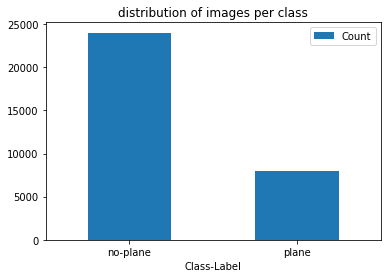

In [11]:
df.plot.bar(rot=0)
plt.title("distribution of images per class");

As it can be seen that the data is skewed towards the *no-ship* class with 75% of images belonging to that very specific class.

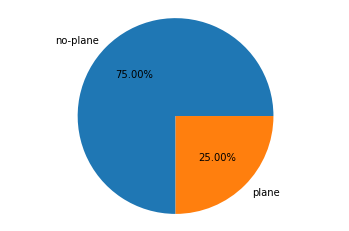

In [12]:
plt.pie(count,
       explode=(0,0),
       labels=class_names,
       autopct="%1.2f%%")
plt.axis('equal');

Due to imbalance in dataset, upsampling is done on the minority class, by randomly duplicating images until the 2 classes have comparable distribution in the dataset. After this is done, the dataset will be split into the training, testing and validation sets by randomly shuffling them and then splitting.

Another way is to introduce class weights for each specific class. Each class is penalised with the specific class weight. Higher the class weight, greater the penalty. Classes with lower percentage have a higher penalty. This allows for the model to penalise itself heavily if class detected is incorrect.

# Augmenting Images of Minority Class

The images present in the *ship* class are augmented and then stored in the dataset, so that there is an equal representation of the classes. The current ratio of classes is 1:3, meaning that for every image present in the *ship* class there are 3 images present in the *no-ship* class. This will be countered by producing 2 augmented images per original image of the *ship* class. This will make the dataset balanced.

If augmentation of dataset is required then set AUGMENTATION to *True*. This will balance the dataset via augmentation of minority classes. To train via class weights, then set AUGMENTATION to *False*.

In [13]:
AUGMENTATION = True

In [14]:
def augment_add(images, seq, labels):

    augmented_images, augmented_labels = [],[]
    for idx,img in tqdm(enumerate(images)):

        if labels[idx] == 1:
            image_aug_1 = seq.augment_image(image=img)
            image_aug_2 = seq.augment_image(image=img)
            augmented_images.append(image_aug_1)
            augmented_images.append(image_aug_2)
            augmented_labels.append(labels[idx])
            augmented_labels.append(labels[idx])
        pass

    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.float32)

    return (augmented_images, augmented_labels)
    pass

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0,0.1)),
    iaa.LinearContrast((0.75,1.5)),
    iaa.Multiply((0.8,1.2), per_channel=0.2),
    iaa.Affine(
        scale={'x':(0.8,1.2), "y":(0.8,1.2)},
        translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)},
        rotate=(-25,25),
        shear=(-8,8)
    )
], random_order=True)

In [16]:
if AUGMENTATION:
    (aug_images, aug_labels) = augment_add(images, seq, labels)
    images = np.concatenate([images, aug_images])
    labels = np.concatenate([labels, aug_labels])

20it [00:00, 69.29it/s]

32000it [00:46, 685.68it/s]  


In [17]:
images.shape, labels.shape

((48000, 20, 20, 3), (48000,))

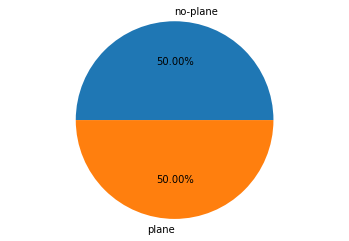

In [18]:
if AUGMENTATION:
    _, count = np.unique(labels, return_counts=True)

    plt.pie(count,
           explode=(0,0),
           labels=class_names,
           autopct="%1.2f%%")
    plt.axis('equal');

# One Hot Encoding Variables

The labels numpy array is one hot encoded using *to_categorical* from keras. This removes any uncessary bias in the dataset, by keeping the class at equal footing, with respect to labels. 

In [19]:
labels = to_categorical(labels)

In [20]:
type(labels)

numpy.ndarray

In [21]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [22]:
labels.shape

(48000, 2)

In [23]:
images.shape

(48000, 20, 20, 3)

# Training, Validation and Testing

Instead of using *train_test_split* the images and labels arrays are randomly shuffled using the same seed value set at *42*. This allows the images and their corresponding labels to remain linked even after shuffling. 

This method allows the user to make all 3 datasets. The training and validation dataset is used for training the model while the testing dataset is used for testing the model on unseen data. Unseen data is used for simulating real-world prediction, as the model has not seen this data before. It allows the developers to see how robust the model is.

In [24]:
np.random.seed(42)
np.random.shuffle(images)

np.random.seed(42)
np.random.shuffle(labels)

## Spliting of data

* 70% - Training
* 20% - Validation
* 10% - Testing

In [25]:
total_count = len(images)
total_count

train = int(0.7*total_count)
val = int(0.2*total_count)
test = int(0.1*total_count)

train_images, train_labels = images[:train], labels[:train]
val_images, val_labels = images[train:(val+train)], labels[train:(val+train)]
test_images, test_labels = images[-test:], labels[-test:]

train_images.shape, val_images.shape, test_images.shape

((33600, 20, 20, 3), (9600, 20, 20, 3), (4800, 20, 20, 3))

If AUGMENTATION is set True, then the number of images per class is balanced. If AUGMENTATION is set to False, then compute the class weights given below and accordingly change the fit function of the Keras API when training.

In [26]:
if not AUGMENTATION:
    count_labels = train_labels.sum(axis=0)

    classTotals = train_labels.sum(axis=0)
    classWeight = {}

    for i in range(0,len(classTotals)):
        classWeight[i] = classTotals.max()/classTotals[i]
        pass
    print(classWeight)

# Creation of model

* **conv_block** - This function contains the convulotional layer, batch normalization and activation layers. The number of filters, kernel_size, strides to be taken are defined by the developer. This allows a developer to make the model without having to repeat the same lines continuously many times. It also uses the OOPs concepts of Python which is recommended instead of coding like it is *C*.

* **basic_model** - This function creates the model using the aforementioned function, max pooling layers and dropouts. After the specified number of convolutional layers, a flatten layer is introduced, along with dense layers so that the image can be classified. The flatten layer converts the feature map produced by the convolutional layers into a single column for classification.

For image detection in images using Faster R-CNN the feature map produced by the convolutional layers is used, i.e., the model drops the layers after the final convolutional block and passes the generated feature map to a Regional Proposal Network, which can either uses a vanilla CNN model containing fully connected layers or a Logistic Regression, Support Vector machines or Random forests. Advised to use vanilla CNN as it uses less CPU and memory, plus slightly faster and capable of giving multiple outputs if required.

## Explanation of features

* Conv2D - This is a 2 dimensional convolutional layer, the number of filters decide what the convolutional layer learns. Greater the number of filters, greater the amount of information obtained.

![Conv2D Visualisation](https://www.pyimagesearch.com/wp-content/uploads/2018/12/keras_conv2d_num_filters.png)

* MaxPooling2D - This reduces the spatial dimensions of the feature map produced by the convolutional layer without losing any range information. This allows a model to become slightly more robust
* Dropout - This removes a user-defined percentage of links between neurons of consecutive layers. This allows the model to be robust. It can be used in both fully convolutional layers and fully connected layers.
* BatchNormalization - This layer normalises the values present in the hidden part of the neural network. This is similar to MinMax/Standard scaling applied in machine learning algorithms
* Padding- This pads the feature map/input image with zeros allowing border features to stay.

In [27]:
def conv_block(X,k,filters,stage,block,s=2):

    conv_base_name = 'conv_' + str(stage)+block+'_branch'
    bn_base_name = 'bn_'+str(stage)+block+"_branch"

    F1 = filters

    X = Conv2D(filters=F1, kernel_size=(k,k), strides=(s,s),
              padding='same',name=conv_base_name+'2a')(X)
    X = BatchNormalization(name=bn_base_name+'2a')(X)
    X = Activation('relu')(X)

    return X
    pass

## Creation of Model

### Block 1
* An input layer is initialised using the Input Keras layer, this defines the number of neurons present in the input layer
* ZeroPadding is applied to the input image, so that boundary features are not lost.
    
### Block 2
* First Convolutioanl Layer, it starts with 16 filters and kernel size with (3,3) and strides (2,2). Padding is maintaned same, so the image does not chaneg spatially, until the next block in which MaxPooling occurs
        
### Block 3 - 4
* Similar structure in both with a convolutional layer followed by a MaxPooling and Dropout layers.

### Output Block
* The feature map produced by the previous convolutional layers is converted into a single column using Flatten Layer and the classified using a Dense layer(output layer) with the number of classes present in the dataset, and *sigmoid* as activation function.

In [35]:
def basic_model(input_shape,classes):

    X_input = Input(input_shape)

    X = ZeroPadding2D((5,5))(X_input)

    X = Conv2D(16,(3,3),strides=(2,2),name='conv1',padding="same")(X)
    X = BatchNormalization(name='bn_conv1')(X)

    # stage 2
    X = conv_block(X,3,32,2,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 3
    X = conv_block(X,5,32,3,block='A',s=2)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 4
    X = conv_block(X,3,64,4,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#   Output Layer
    X = Flatten()(X)
    X = Dense(64)(X)
    X = Dropout(0.5)(X)

    X = Dense(128)(X)
    X = Activation("relu")(X)

    X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)

    model = Model(inputs=X_input,outputs=X,name='Feature_Extraction_and_FC')

    return model
    pass

In [36]:
model = basic_model(input_shape=(20,20,3),classes=2)

In [37]:
plot_model(model,to_file='basic_model.png')
SVG(model_to_dot(model= model).create(prog='dot',format='svg'))

model.summary()

Model: "Feature_Extraction_and_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 20, 3)]       0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 30, 30, 3)        0         
 ng2D)                                                           
                                                                 
 conv1 (Conv2D)              (None, 15, 15, 16)        448       
                                                                 
 bn_conv1 (BatchNormalizatio  (None, 15, 15, 16)       64        
 n)                                                              
                                                                 
 conv_2A_branch2a (Conv2D)   (None, 15, 15, 32)        4640      
                                                                 
 bn_2A_branch2a (BatchNormal  (None, 15, 

## Compiling the Model

The model is compiled using the *Adam* optimizer with learning rate set at 1e-3. *Binary Crossentropy* is used as a loss function as there are only two classes.

In [38]:
opt = Adam(lr=1e-3)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

In [39]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
logs = TensorBoard("logs")

In [40]:
type(train_images)

numpy.ndarray

# Training model

The model is trained for 50 epochs with a batch size of 16. The best model weights are stored in the file *model_weight.h5* with TensorBoard logs being stored in the *logs* directory.

In [41]:
epochs = 50
batch_size = 16

history = model.fit(train_images,train_labels,
                   steps_per_epoch=len(train_images)//batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(val_images,val_labels),
                   validation_steps=len(val_images)//batch_size,
                   callbacks=[checkpoint, logs]
#                    class_weight=classWeight # Uncomment if AUGMENTATION is set to FALSE
                   )

Epoch 1/50


2098/2100 [============================>.] - ETA: 0s - loss: 0.2924 - accuracy: 0.8688
Epoch 00001: val_accuracy improved from -inf to 0.94083, saving model to model_weights.h5
2100/2100 [==============================] - 47s 22ms/step - loss: 0.2922 - accuracy: 0.8689 - val_loss: 0.1437 - val_accuracy: 0.9408
Epoch 2/50
2098/2100 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9374
Epoch 00002: val_accuracy improved from 0.94083 to 0.95312, saving model to model_weights.h5
2100/2100 [==============================] - 43s 20ms/step - loss: 0.1655 - accuracy: 0.9374 - val_loss: 0.1286 - val_accuracy: 0.9531
Epoch 3/50
2100/2100 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9480
Epoch 00003: val_accuracy did not improve from 0.95312
2100/2100 [==============================] - 42s 20ms/step - loss: 0.1380 - accuracy: 0.9480 - val_loss: 0.3441 - val_accuracy: 0.8528
Epoch 4/50
2099/2100 [============================>.] - ETA: 0s - loss: 0.

# Plotting Loss and Accuracy

The loss and accuracy for the training and validation datasets is plotted using the *show_final_history* function

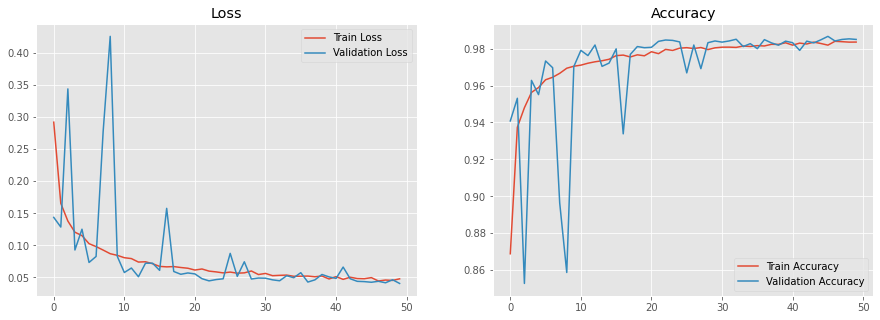

In [42]:
show_final_history(history)

# Confusion Matrix for Validation dataset

The confusion matrix

In [43]:
val_pred = model.predict(val_images)
val_pred = np.argmax(val_pred,axis=1)
val_pred.shape

(9600,)

/tmp/ipykernel_6040/1360290468.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


<Figure size 432x288 with 0 Axes>

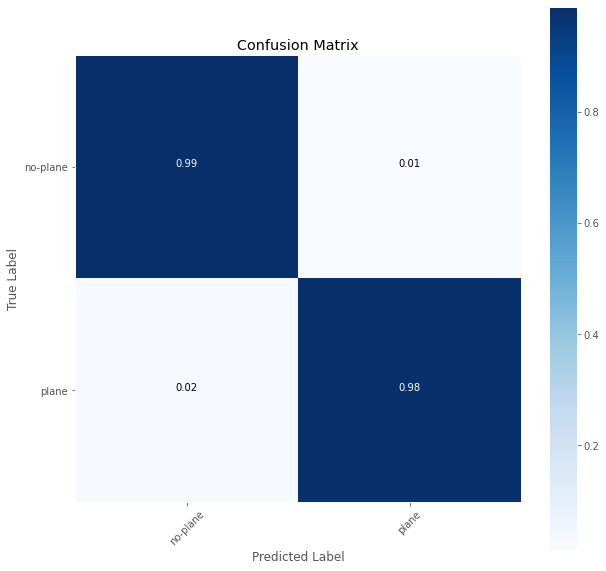

In [44]:
val_actual = np.argmax(val_labels,axis=1)

cnf_mat = confusion_matrix(val_actual, val_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.grid(None)
plt.show();

### With Augmentation:

* Precision:
    - *no-ship* : 0.942
    - *ship* : 0.989


* Recall:
    - *no-ship* : 0.99
    - *ship* : 0.94
    
### With class weights

* Precision:
    - *no-ship* : 1.00
    - *ship* : 0.99


* Recall:
    - *no-ship* : 0.99
    - *ship* : 1.00

# Confusion Matrix for Testing Dataset

In [45]:
test_pred = model.predict(test_images)
test_pred = np.argmax(test_pred,axis=1)
test_pred.shape

(4800,)

/tmp/ipykernel_6040/1360290468.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


<Figure size 432x288 with 0 Axes>

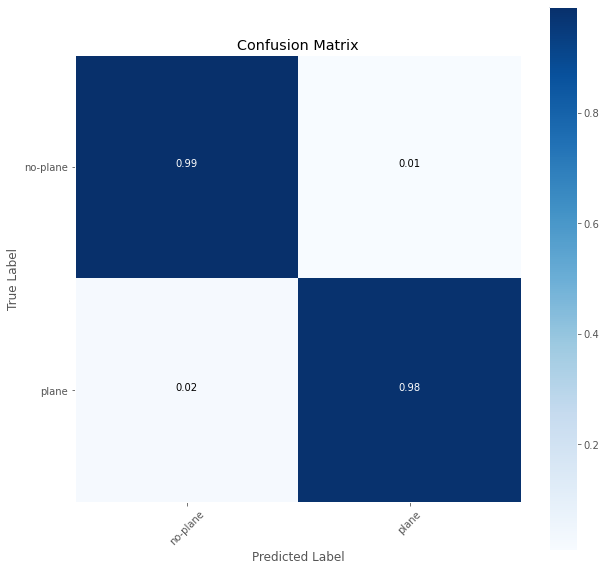

In [46]:
test_actual = np.argmax(test_labels,axis=1)

cnf_mat_test = confusion_matrix(test_actual, test_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat_test,classes=class_names)
plt.grid(None)
plt.show()

# Checking the model

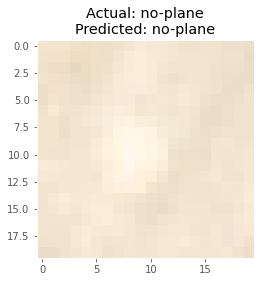

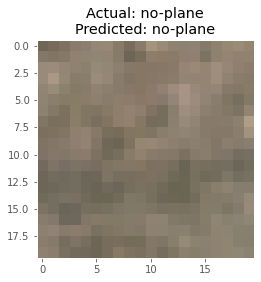

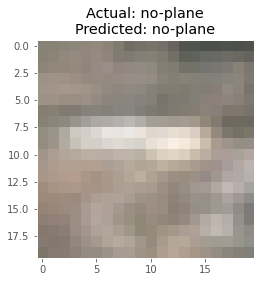

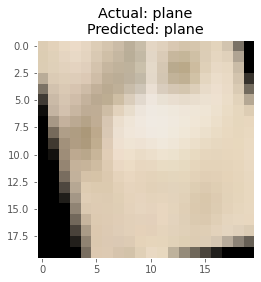

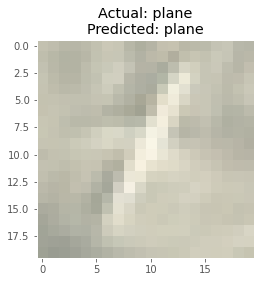

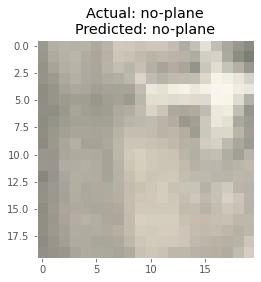

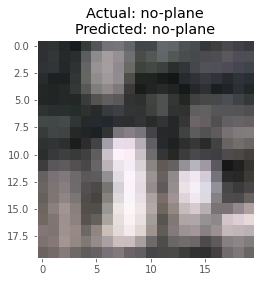

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


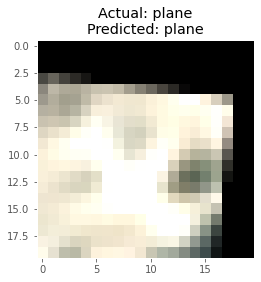

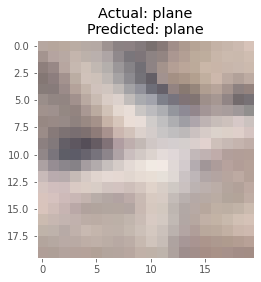

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


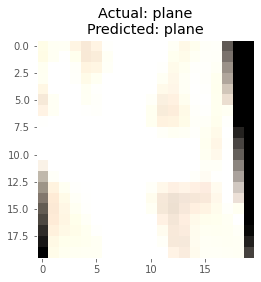

In [47]:
rnd_idx = random.sample(range(0,400),10)

class_labels = {i:class_name for (class_name,i) in class_name_labels.items()}
class_labels

# fig, ax = plt.subplots(2,5,figsize=(5,5))

for i,idx in enumerate(rnd_idx):

    plt.imshow(test_images[idx])
    plt.title("Actual: {}\nPredicted: {}".format(class_labels[test_actual[idx]],class_labels[test_pred[idx]]))
    plt.grid(None)
    plt.show()
    pass

**Saving the model**

In [48]:
model.save("plane-model.h5")